In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn  as nn
import math
import cv2
from torch.autograd import Variable
import torch.nn.functional as F
from collections import OrderedDict

from torchsummary import summary
import tensorflow as tf
import re

class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=5,stride=2,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            )
        
        self.conv1 = nn.Conv2d(3,64,kernel_size=5,stride=2,padding=2)
        self.conv2 = nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1)
        self.conv3 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.MP = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(256*7*7,512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,5)
        
        
        self.classfier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*7*7,512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,5),
            )
        

    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.MP(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.MP(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.MP(x)
        x = x.view(x.size(0),256*7*7)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        #x = self.features(x)
        #x = x.view(x.size(0),256*7*7)
        #x = self.classfier(x)
        
        return x
    
alex = AlexNet()

# Retrieve weights from TF checkpoint
tf_path = os.path.abspath('models/grasp/m4/m4.ckpt')
init_vars = tf.train.list_variables(tf_path)
tf_vars = {}
for name, shape in init_vars:
    print("Loading TF weight {} with shape {}".format(name, shape))
    array = tf.train.load_variable(tf_path, name)
    tf_vars[name] = torch.from_numpy(array.squeeze())
    #tf_vars.append((name, array.squeeze()))
    
#loading weights

alex.conv1.weight.data = tf_vars['w1'].transpose(0,3).transpose(1,2)
alex.conv2.weight.data = tf_vars['w2'].transpose(0,3).transpose(1,2)
alex.conv3.weight.data = tf_vars['w3'].transpose(0,3).transpose(1,2)
alex.conv4.weight.data = tf_vars['w4'].transpose(0,3).transpose(1,2)
alex.conv5.weight.data = tf_vars['w5'].transpose(0,3).transpose(1,2)

alex.conv1.bias.data = tf_vars['b1']
alex.conv2.bias.data = tf_vars['b2']
alex.conv3.bias.data = tf_vars['b3']
alex.conv4.bias.data = tf_vars['b4']
alex.conv5.bias.data = tf_vars['b5']

alex.fc1.weight.data = tf_vars['w_fc1'].transpose(0,1)
alex.fc2.weight.data = tf_vars['w_fc2'].transpose(0,1)
alex.fc3.weight.data = tf_vars['w_output'].transpose(0,1)

alex.fc1.bias.data = tf_vars['b_fc1']
alex.fc2.bias.data = tf_vars['b_fc2']
alex.fc3.bias.data = tf_vars['b_output']

def default_loader(path):
    im = plt.imread(path)
    im = im[128:352,208:432,:]
    plt.imshow(im)
    im = im.transpose(2,0,1)
    im = np.expand_dims(im,0)
    im = torch.from_numpy(im).float()
    return im

def grasp_to_bbox(x, y, tan, h, w):
    theta = math.atan(tan)
    edge1 = (x -w/2*math.cos(theta) +h/2*math.sin(theta), y -w/2*math.sin(theta) -h/2*math.cos(theta))
    edge2 = (x +w/2*math.cos(theta) +h/2*math.sin(theta), y +w/2*math.sin(theta) -h/2*math.cos(theta))
    edge3 = (x +w/2*math.cos(theta) -h/2*math.sin(theta), y +w/2*math.sin(theta) +h/2*math.cos(theta))
    edge4 = (x -w/2*math.cos(theta) -h/2*math.sin(theta), y -w/2*math.sin(theta) +h/2*math.cos(theta))
    return [edge1, edge2, edge3, edge4]

def draw_bbox(img, bbox):
    p1 = (int(float(bbox[0][0]) / 0.35), int(float(bbox[0][1]) / 0.47))
    p2 = (int(float(bbox[1][0]) / 0.35), int(float(bbox[1][1]) / 0.47))
    p3 = (int(float(bbox[2][0]) / 0.35), int(float(bbox[2][1]) / 0.47))
    p4 = (int(float(bbox[3][0]) / 0.35), int(float(bbox[3][1]) / 0.47))

    #cv2.line(img, (100,100),(200,200), (0, 0, 255))
    '''
    print(p1)
    print(p2)
    print(p3)
    print(p4)
    '''
    cv2.line(img, p1, p2, (0, 0, 255))
    cv2.line(img, p2, p3, (0, 0, 255))
    cv2.line(img, p3, p4, (0, 0, 255))
    cv2.line(img, p4, p1, (0, 0, 255))

Loading TF weight b1 with shape [64]
Loading TF weight b2 with shape [128]
Loading TF weight b3 with shape [128]
Loading TF weight b4 with shape [128]
Loading TF weight b5 with shape [256]
Loading TF weight b_fc1 with shape [512]
Loading TF weight b_fc2 with shape [512]
Loading TF weight b_output with shape [5]
Loading TF weight w1 with shape [5, 5, 3, 64]
Loading TF weight w2 with shape [3, 3, 64, 128]
Loading TF weight w3 with shape [3, 3, 128, 128]
Loading TF weight w4 with shape [3, 3, 128, 128]
Loading TF weight w5 with shape [3, 3, 128, 256]
Loading TF weight w_fc1 with shape [12544, 512]
Loading TF weight w_fc2 with shape [512, 512]
Loading TF weight w_output with shape [512, 5]


In [18]:
#Run inference


for i in range(num_examples):
    img_path = '.dataset/01/01'
img_path = './dataset/01/01/pcd0100r.png'
img = default_loader(img_path)
pred = alex(img)
out = pred.detach().numpy().squeeze()
edges = grasp_to_bbox(out[0],out[1],out[2],out[3],out[4])

img_show = cv2.imread(img_path)
draw_bbox(img_show, edges)
cv2.imshow('bbox', img_show)
cv2.waitKey(0)

NameError: name 'num_examples' is not defined

./outputs/OUT_pcd0130r.png
./outputs/OUT_pcd0179r.png
./outputs/OUT_pcd0178r.png
./outputs/OUT_pcd0136r.png
./outputs/OUT_pcd0116r.png
./outputs/OUT_pcd0101r.png
./outputs/OUT_pcd0189r.png
./outputs/OUT_pcd0181r.png
./outputs/OUT_pcd0120r.png
./outputs/OUT_pcd0173r.png
./outputs/OUT_pcd0144r.png
./outputs/OUT_pcd0180r.png
./outputs/OUT_pcd0151r.png
./outputs/OUT_pcd0186r.png
./outputs/OUT_pcd0169r.png
./outputs/OUT_pcd0104r.png
./outputs/OUT_pcd0183r.png
./outputs/OUT_pcd0145r.png
./outputs/OUT_pcd0142r.png
./outputs/OUT_pcd0171r.png
./outputs/OUT_pcd0147r.png
./outputs/OUT_pcd0115r.png
./outputs/OUT_pcd0194r.png
./outputs/OUT_pcd0105r.png
./outputs/OUT_pcd0150r.png
./outputs/OUT_pcd0134r.png
./outputs/OUT_pcd0123r.png
./outputs/OUT_pcd0110r.png
./outputs/OUT_pcd0160r.png
./outputs/OUT_pcd0152r.png
./outputs/OUT_pcd0117r.png
./outputs/OUT_pcd0146r.png
./outputs/OUT_pcd0114r.png
./outputs/OUT_pcd0108r.png
./outputs/OUT_pcd0107r.png
./outputs/OUT_pcd0195r.png
./outputs/OUT_pcd0192r.png
.

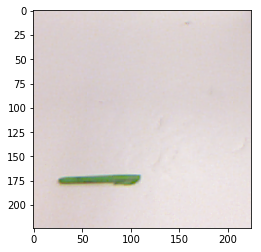

In [21]:
import os
import re
image_names = []
rootdir = './dataset/01/01/'
for root, dirs, files in os.walk(rootdir):
    for file in files:
        if re.search('.png$', file):
            image_names.append(file)

for image_name in image_names:
    img_path = rootdir + image_name
    
    img = default_loader(img_path)
    pred = alex(img)
    out = pred.detach().numpy().squeeze()
    edges = grasp_to_bbox(out[0],out[1],out[2],out[3],out[4])
    
    img_show = cv2.imread(img_path)
    draw_bbox(img_show, edges)
    output_path = './outputs/' + 'OUT_' + image_name
    cv2.imwrite(output_path, img_show)
    print(output_path)
    